In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# 1. Résolution numérique du problème de Laplace

## 1.1. Factorisation d'une matrice tridiagonale

- On considère une matrice tridiagonale de la forme

$$
\begin{align*}
    A_{i,i}     &= diag(i)  &&\text{si } i=1, \dots, n \\
    A_{i, i-1}  &= low(i)   &&\text{si } i=2, \dots, n \\
    A_{i, i+1}  &= sup(i)   &&\text{si } i=2, \dots, n \\
    A_{i, j}    &= 0        &&\text{sinon.}
\end{align*}
$$

- On définit une fonction `factolu(low, diag, sup)` qui calcule la factorisation LU de $A$ et la stocke dans les mêmes tableaux `low`, `diag` et `sup`.

In [2]:
def factolu(low, diag, sup):
    for i in range(len(diag)-1):
        low[i] = low[i] / diag[i]
        diag[i+1] = diag[i+1] - low[i] * sup[i]

- On définit une fonction `solvelu(low, diag, sup, x)` qui effectue un algorithme de descente remontée pour résoudre le système $Ax = b$ et stocke le résultat dans `x`.

In [3]:
def solvelu(low, diag, sup, x):
    n = len(diag)

    # Descente
    for i in range(1, n):
        x[i] = x[i] - low[i-1] * x[i-1]

    # Remontée
    x[n-1] = x[n-1] / diag[n-1]
    for i in range(n-2, -1, -1):
        x[i] = (x[i] - sup[i] * x[i+1]) / diag[i]

- On définit, enfin, une fonction `dot(low, diag, sup, x)` qui renvoie le produit $Ax$.

In [4]:
def dot(low, diag, sup, x):
    n = len(x)
    Ax = np.zeros(n)
    
    Ax[0] = diag[0] * x[0] + sup[0] * x[1]
    Ax[n-1] = low[n-2] * x[n-2] + diag[n-1] * x[n-1]

    Ax[1:n-1] = [low[i-1] * x[i-1] + diag[i] * x[i] + sup[i] * x[i+1] for i in range(1, n-1)]
    
    return Ax

- Testons ces fonctions

In [5]:
n = 10

A_low = np.random.rand(n-1) + 0.5
A_diag = np.random.rand(n) + 0.5
A_sup = np.random.rand(n-1) + 0.5

low = np.copy(A_low)
diag = np.copy(A_diag)
sup = np.copy(A_sup)

b = np.random.random(n)
x = np.copy(b)

factolu(low, diag, sup)
solvelu(low, diag, sup, x)

print("La solution approchée du système Ax=b est : \n x =", x)

Ax = dot(A_low, A_diag, A_sup, x)
erreur = np.linalg.norm(Ax - b)

print("\nL\'erreur commise est de {0}".format(erreur))

La solution approchée du système Ax=b est : 
 x = [ 0.225126   -0.30383087  1.08061232 -0.52977701  0.75488338  0.26088432
 -1.16670458  0.80944838  2.8780381  -2.88457177]

L'erreur commise est de 7.947987303456224e-16


## 1.2. Application : Problème de Laplace en dimension 1

### 1. Discrétisation par différences finies du problème de Dirichlet

$$
    \begin{align*}
        -u''(x)        &= f(x),    && x\in]0, L[\,, \\
        u(0) = u(L)    &= 0
    \end{align*}
$$

- On découpe l’intervalle $[0, L]$ en $n + 2$ points équi-répartis, de la façon suivante :
  $$
      \forall i \in [0, n + 1],\; x_i = i \Delta x,\quad \text{ avec } \Delta x = \frac{L}{n + 1}.
  $$
  Avec $u_i \simeq u(x_i)$ pour $i \in [0, n]$, on obtient le schéma suivant :
  $$
      \begin{cases}
          u_0 &= 0 \\
          f(x_i) &= -\frac{u_{i-1} - 2u_i + u_{i+1}}{{\Delta x}^2} \qquad \forall i \in [1, n] \\
          u_{n+1} &= 0
      \end{cases}
  $$


- En écrivant cette discrétisation sous la forme matricielle : $Mv = g$, où $M \in M_n(\mathbb{R})$, $v \in \mathbb{R}^n$ et $g \in \mathbb{R}^n$, on obtient
  $$
      M = \frac{1}{\Delta x^2}
          \begin{pmatrix}
              2   &-1     &       &       &   \\
              -1  &2      &-1     &       &   \\
                  &\ddots  &\ddots &\ddots &  \\
                  &       &-1     &2      &-1 \\
                  &       &       &-1     &2
          \end{pmatrix}\,,\; v =
          \begin{pmatrix}
              u_1     \\
              u_2     \\
              \vdots  \\
              u_{n-1} \\
              u_n
          \end{pmatrix} \; \text{et} \; g =
          \begin{pmatrix}
              f(x_1)    \\
              f(x_2)    \\
              \vdots    \\
              f(x_{n-1})\\
              f(x_n)
          \end{pmatrix}
  $$
  On remarque que $M$ est tridiagonale.

### 2. Fonction résolvant le problème de Laplace avec le schéma numérique obtenu.

In [6]:
def solve_Laplace(L, f, nx, BC='DD'):
    dx = L/(nx + 1)  # Calcul de dx

    # Calcul du vecteur g en utilisant une liste en compréhension
    g = np.array([f(i * dx) for i in range(1, nx + 1)])

    # Construction des diagonale de M
    low = np.full(nx - 1, -1.0)
    diag = np.full(nx, 2.0)
    sup = np.full(nx - 1, -1.0)

    if BC[0] == 'N':  # Neumann à gauche
        diag[0] = 1

    if BC[1] == 'N':  # Neumann à droite
        diag[-1] = 1

    v = g * dx**2

    factolu(low, diag, sup)  # Factorisation LU de M
    solvelu(low, diag, sup, v)  # Résolution du système Mv=g

    return v

### 3. Vérification numérique de la convergence de la méthode lorsque $\Delta x \rightarrow 0$.

- Soit $u(x) = \sin(\pi p x) \exp(-\lambda x)$
  \begin{align*}
    u'(x)  &= \pi p \cos(\pi  px) \exp(−\lambda x) − \lambda  \sin(\pi px) \exp(−\lambda x) \\
           &= (\pi p \cos(\pi px) −\lambda  \sin(\pi px)) \exp(−\lambda x) \\
    u''(x) &= (−\pi^2 p^2 \sin(\pi  px) − \lambda \pi p \cos(\pi px)) \exp(−\lambda x) − \lambda (\pi p \cos(\pi px) − \lambda  \sin(\pi px)) \exp(−\lambda x) \\
           &= ((\lambda^2 − \pi^2 p^2) \sin(\pi  px) − 2\lambda \pi  p \cos(\pi  px)) \exp(−\lambda x) \\
           \\
    \Rightarrow f(x) &= ((\lambda^2 − \pi^2 p^2) \sin(\pi  px) − 2\lambda \pi  p \cos(\pi  px)) \exp(−\lambda x)
  \end{align*}
  On définit l'erreur $e(\Delta x)$ par
  $$
       e(\Delta x) = \sup_{i=1,...,n} \left|u_i − u\left(\frac{iL}{n + 1}\right) \right|
  $$

In [7]:
def uexact(x, p, Lambda):  # Retourne u(x) exact
    return np.sin(np.pi * p * x) * np.exp(-Lambda * x)


def f(x, p, Lambda):  # Retourne f(x)
    return ((np.pi**2 * p**2 - Lambda**2) * np.sin(np.pi * p * x) + 2 * Lambda * np.pi * p * np.cos(np.pi * p * x)) * np.exp(-Lambda * x)


def create_g(f, p, Lambda):  # Retourne la fonction retournant g(x)
    return lambda x: f(x, p, Lambda)

def erreur(L, f, nx, uexact, BC='DD'): # Retourne l'erreur e(Δx)
    v = solve_Laplace(L, f, nx, BC)
    dx = L / (nx + 1)
    vexact = [uexact(i*dx) for i in range(1, nx+1)]

    return np.abs(v - vexact).max()

- Calculons et traçon $\mathrm{ln}(e(\Delta x))$ en fonction de $\mathrm{ln}(\Delta x)$ pour diverses valeurs de $\lambda \in \mathbb{R}$ et $p \in \mathbb{N}$.

L'erreur commise avec 100 points est de 2.26e-04


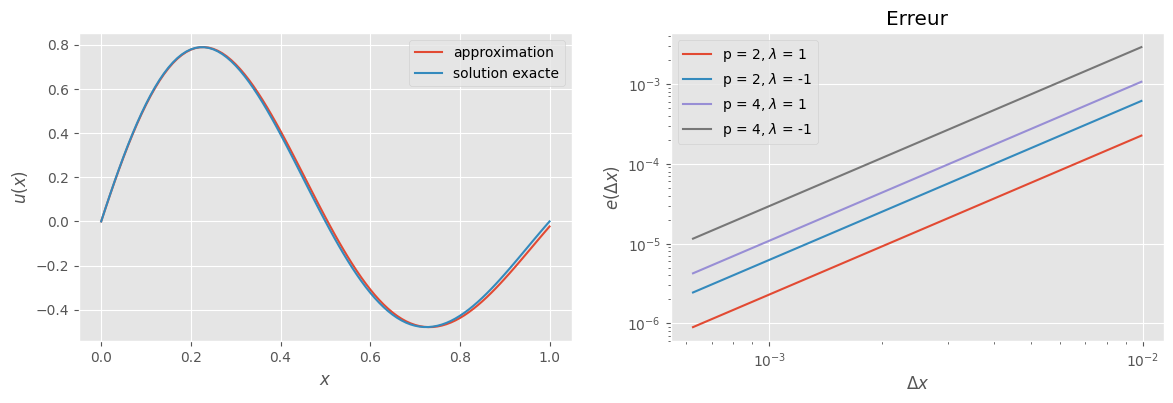

In [8]:
L = 1
l = 1
p = 2
n = 100
x = np.linspace(0, L, n+1)

u = solve_Laplace(L, create_g(f, p, l), n)
u = np.concatenate(([0], u))

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(x, u, label="approximation")
ax[0].plot(x, uexact(x, p, l), label="solution exacte")
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$u(x)$')
ax[0].legend()

print("L\'erreur commise avec {0} points est de {1:4.2e}".format(
    n, erreur(L, create_g(f, p, l), n, create_g(uexact, p, l))))

all_n = [100 * 2**i for i in range(5)]

for i_p, p in enumerate([2, 4]):
    for i_l, l in enumerate([1, -1]):
        e = np.zeros(len(all_n))
        delta = np.zeros(len(all_n))

        for i_n, n in enumerate(all_n):
            g = create_g(f, p, l)
            h = create_g(uexact, p, l)

            e[i_n] = erreur(L, g, n, h)
            delta[i_n] = L / (n + 1)

        ax[1].loglog(delta, e, label=r"p = {0}, $\lambda$ = {1}".format(p, l))

ax[1].set_title('Erreur')
ax[1].set_xlabel(r'$\Delta x$')
ax[1].set_ylabel(r'$e(\Delta x)$')
ax[1].legend()

plt.show()


### 4. Même étude pour le problème mixte de Dirichlet-Neumann

$$
    −u''(x) = f(x),\; x \in ]0,L[,\; u'(0) = u(L) = 0.
$$

In [9]:
def uexact_DN(x, p, l):
    return np.cos(np.pi * p * x) - 1

def f_DN(x, p, l):
    return np.pi**2 * p**2 * np.cos(np.pi * p * x)

L'erreur commise avec 100 points est de 1.94e-01


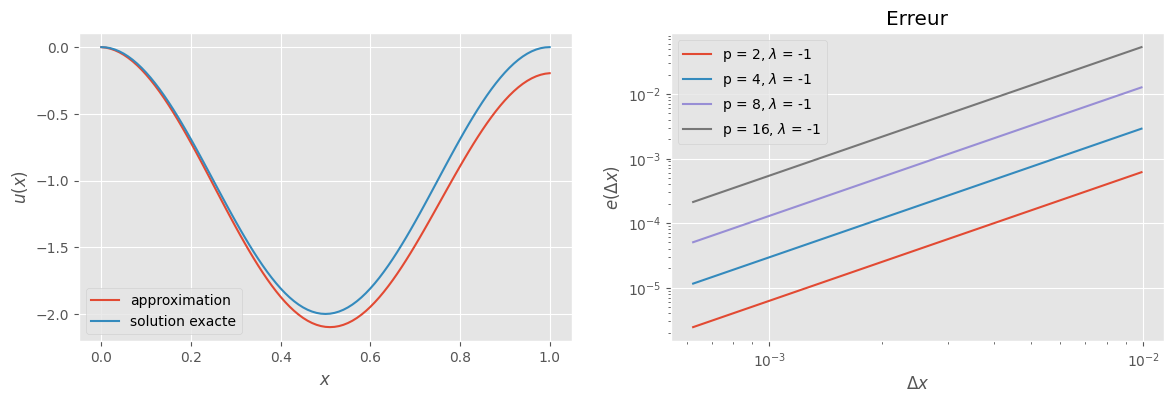

In [10]:
L = 1
p = 2
n = 100
x = np.linspace(0, L, n+1)

u = solve_Laplace(L, create_g(f_DN, p, l), n, BC='DN')
u = np.concatenate(([0], u))

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(x, u, label="approximation")
ax[0].plot(x, uexact_DN(x, p, l), label="solution exacte")
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$u(x)$')
ax[0].legend()

print("L\'erreur commise avec {0} points est de {1:4.2e}".format(
    n, erreur(L, create_g(f_DN, p, l), n, create_g(uexact_DN, p, l), BC='DN')))

all_n = [100 * 2**i for i in range(5)]

for i_p, p in enumerate([2, 4, 8, 16]):
    e = np.zeros(len(all_n))
    delta = np.zeros(len(all_n))

    for i_n, n in enumerate(all_n):
        g = create_g(f, p, l)
        h = create_g(uexact, p, l)

        e[i_n] = erreur(L, g, n, h)
        delta[i_n] = L / (n + 1)

    ax[1].loglog(delta, e, label=r"p = {0}, $\lambda$ = {1}".format(p, l))

ax[1].set_title('Erreur')
ax[1].set_xlabel(r'$\Delta x$')
ax[1].set_ylabel(r'$e(\Delta x)$')
ax[1].legend()
plt.show()
